In [46]:
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import plotly.express as px

In [47]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [48]:
# Let's define some constants

datasets = [
    "kuhar",
    "motionsense",
    "uci",
    "wisdm",
    "realworld"
]


labels_activity = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down",
}

In [74]:
# Let's define some filters
def only_fft(df):
    return df[df["transforms"].str.contains("FFT")]


def only_time(df):
    return df.loc[df["transforms"] == ""]


def using_all_features(df):
    return df[
        df["in_use_features"].str.contains("accel-x")
        & df["in_use_features"].str.contains("accel-y")
        & df["in_use_features"].str.contains("accel-z")
        & df["in_use_features"].str.contains("gyro-x")
        & df["in_use_features"].str.contains("gyro-y")
        & df["in_use_features"].str.contains("gyro-z")
    ]


def using_only_accel(df):
    return df[
        df["in_use_features"].str.contains("accel-x")
        & df["in_use_features"].str.contains("accel-y")
        & df["in_use_features"].str.contains("accel-z")
        & ~df["in_use_features"].str.contains("gyro-x")
        & ~df["in_use_features"].str.contains("gyro-y")
        & ~df["in_use_features"].str.contains("gyro-z")
    ]


def using_only_gyro(df):
    return df[
        ~df["in_use_features"].str.contains("accel-x")
        & ~df["in_use_features"].str.contains("accel-y")
        & ~df["in_use_features"].str.contains("accel-z")
        & df["in_use_features"].str.contains("gyro-x")
        & df["in_use_features"].str.contains("gyro-y")
        & df["in_use_features"].str.contains("gyro-z")
    ]


def only_reduce_on_all(df):
    return df[df["reduce_on"] == "all"]


def only_reduce_on_sensor(df):
    return df[df["reduce_on"] == "sensor"]


def only_reduce_on_axis(df):
    return df[df["reduce_on"] == "axis"]


def only_rf(df):
    return df[df["estimator"].str.lower().str.contains("randomforest")]


def only_svm(df):
    return df[df["estimator"].str.lower().str.contains("svm")]


def only_knn(df):
    return df[df["estimator"].str.lower().str.contains("knn")]


def no_scaler(df):
    return df[df["scaler"] == ""]

def min_max_scaler(df):
    return df[df["scaler"].str.lower().str.contains("minmaxscaler")]

def standard_scaler(df):
   return df[df["scaler"].str.lower().str.contains("standardscaler")]

def only_reducer_equals_train(df):
    return df[df["reducer_datasets"] == df["train_datasets"]]

def only_reducer_equals_train_or_no_reduce(df):
    return df[(df["reducer_datasets"] == df["train_datasets"]) | (df["reducer_datasets"] == "")]


def rename_datasets(
    df, columns: List[str] = ("reducer_datasets", "train_datasets", "test_datasets")
):
    def rename_row(row):
        for col in columns:
            names = set()
            for name in row[col].split(","):
                name = name.strip()
                names.add(name.split(".")[0])
            row[col] = ", ".join(sorted(names))
        return row

    df = df.apply(rename_row, axis=1)
    return df


def add_view_name(df, new_column_name: str = "view"):
    df[new_column_name] = df["config_id"].apply(lambda x: "_".join(x.split("_")[:-1]))
    return df


def match_configs(df, new_column_name: str = "config_group"):
    group_no = 0
    for k, subdf in df.groupby(
        [
            "in_use_features",
            "scale_on",
            "reduce_on",
            "transforms",
            "scaler",
            "reducer",
            "umap components",
            "reducer_datasets",
            "train_datasets",
            "test_datasets",
            "estimator",
        ]
    ):
        if len(subdf) == 2:
            df.loc[subdf.index, new_column_name] = group_no
            group_no += 1
    return df


In [69]:
results_file = Path("results.csv")
results = pd.read_csv(results_file).fillna("")
results

,experiment_name,run_name,config_id,reduce_size,train_size,test_size,in_use_features,scale_on,reduce_on,transforms,scaler,reducer,umap components,reducer_datasets,train_datasets,test_datasets,estimator,accuracy (mean),accuracy (std),f1-score macro (mean),f1-score macro (std),f1-score weighted (mean),f1-score weighted (std)
0,reducer_comb_1,execution1,standartized_intra_balanced_08609,0,1495,120,"gyro-x, gyro-y, gyro-z",train,sensor,,,umap-7,7,,"wisdm.standartized_intra_balanced[train], wisd...",wisdm.standartized_intra_balanced[test],randomforest-100,0.670833,2.770128e-02,0.667083,3.039176e-02,0.667083,3.039176e-02
1,reducer_comb_1,execution1,standartized_intra_balanced_08609,0,1495,120,"gyro-x, gyro-y, gyro-z",train,sensor,,,umap-7,7,,"wisdm.standartized_intra_balanced[train], wisd...",wisdm.standartized_intra_balanced[test],KNN-5,0.541667,1.110223e-16,0.540794,0.000000e+00,0.540794,0.000000e+00
2,reducer_comb_1,execution1,standartized_intra_balanced_08609,0,1495,120,"gyro-x, gyro-y, gyro-z",train,sensor,,,umap-7,7,,"wisdm.standartized_intra_balanced[train], wisd...",wisdm.standartized_intra_balanced[test],SVM-rbf-C1.0,0.583333,1.110223e-16,0.521068,0.000000e+00,0.521068,0.000000e+00
3,reducer_comb_1,execution1,standartized_intra_balanced_00845,0,1794,144,"accel-x, accel-y, accel-z, gyro-x, gyro-y, gyro-z",train,sensor,,MinMaxScaler,umap-2,2,,"kuhar.standartized_intra_balanced[train], kuha...",kuhar.standartized_intra_balanced[test],randomforest-100,0.800694,1.812221e-02,0.795044,1.921549e-02,0.795044,1.921549e-02
4,reducer_comb_1,execution1,standartized_intra_balanced_00845,0,1794,144,"accel-x, accel-y, accel-z, gyro-x, gyro-y, gyro-z",train,sensor,,MinMaxScaler,umap-2,2,,"kuhar.standartized_intra_balanced[train], kuha...",kuhar.standartized_intra_balanced[test],KNN-5,0.493056,5.551115e-17,0.482479,0.000000e+00,0.482479,5.551115e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63172,reducer_comb_1,execution1,raw_balanced_02926,3978,3978,1062,"accel-x, accel-y, accel-z, gyro-x, gyro-y, gyro-z",train,all,FFT-centered,MinMaxScaler,umap-20,20,"motionsense.raw_balanced[train], motionsense.r...","motionsense.raw_balanced[train], motionsense.r...",motionsense.raw_balanced[test],KNN-5,0.883239,1.110223e-16,0.883064,1.110223e-16,0.883064,0.000000e+00
63173,reducer_comb_1,execution1,raw_balanced_02926,3978,3978,1062,"accel-x, accel-y, accel-z, gyro-x, gyro-y, gyro-z",train,all,FFT-centered,MinMaxScaler,umap-20,20,"motionsense.raw_balanced[train], motionsense.r...","motionsense.raw_balanced[train], motionsense.r...",motionsense.raw_balanced[test],SVM-rbf-C1.0,0.870998,1.110223e-16,0.871440,1.110223e-16,0.871440,1.110223e-16
63174,reducer_comb_1,execution1,standartized_intra_balanced_05531,0,1794,144,"accel-x, accel-y, accel-z",train,sensor,,StandardScaler,umap-5,5,,motionsense.standartized_intra_balanced[train]...,motionsense.standartized_intra_balanced[test],randomforest-100,0.798611,1.889093e-02,0.796915,1.948198e-02,0.796915,1.948198e-02
63175,reducer_comb_1,execution1,standartized_intra_balanced_05531,0,1794,144,"accel-x, accel-y, accel-z",train,sensor,,StandardScaler,umap-5,5,,motionsense.standartized_intra_balanced[train]...,motionsense.standartized_intra_balanced[test],KNN-5,0.562500,0.000000e+00,0.546329,0.000000e+00,0.546329,0.000000e+00


In [71]:
results = rename_datasets(results)
results = add_view_name(results)
results = match_configs(results)
results

,experiment_name,run_name,config_id,reduce_size,train_size,test_size,in_use_features,scale_on,reduce_on,transforms,scaler,reducer,umap components,reducer_datasets,train_datasets,test_datasets,estimator,accuracy (mean),accuracy (std),f1-score macro (mean),f1-score macro (std),f1-score weighted (mean),f1-score weighted (std),view,config_group
0,reducer_comb_1,execution1,standartized_intra_balanced_08609,0,1495,120,"gyro-x, gyro-y, gyro-z",train,sensor,,,umap-7,7,,wisdm,wisdm,randomforest-100,0.670833,2.770128e-02,0.667083,3.039176e-02,0.667083,3.039176e-02,standartized_intra_balanced,NaN
1,reducer_comb_1,execution1,standartized_intra_balanced_08609,0,1495,120,"gyro-x, gyro-y, gyro-z",train,sensor,,,umap-7,7,,wisdm,wisdm,KNN-5,0.541667,1.110223e-16,0.540794,0.000000e+00,0.540794,0.000000e+00,standartized_intra_balanced,NaN
2,reducer_comb_1,execution1,standartized_intra_balanced_08609,0,1495,120,"gyro-x, gyro-y, gyro-z",train,sensor,,,umap-7,7,,wisdm,wisdm,SVM-rbf-C1.0,0.583333,1.110223e-16,0.521068,0.000000e+00,0.521068,0.000000e+00,standartized_intra_balanced,NaN
3,reducer_comb_1,execution1,standartized_intra_balanced_00845,0,1794,144,"accel-x, accel-y, accel-z, gyro-x, gyro-y, gyro-z",train,sensor,,MinMaxScaler,umap-2,2,,kuhar,kuhar,randomforest-100,0.800694,1.812221e-02,0.795044,1.921549e-02,0.795044,1.921549e-02,standartized_intra_balanced,NaN
4,reducer_comb_1,execution1,standartized_intra_balanced_00845,0,1794,144,"accel-x, accel-y, accel-z, gyro-x, gyro-y, gyro-z",train,sensor,,MinMaxScaler,umap-2,2,,kuhar,kuhar,KNN-5,0.493056,5.551115e-17,0.482479,0.000000e+00,0.482479,5.551115e-17,standartized_intra_balanced,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63172,reducer_comb_1,execution1,raw_balanced_02926,3978,3978,1062,"accel-x, accel-y, accel-z, gyro-x, gyro-y, gyro-z",train,all,FFT-centered,MinMaxScaler,umap-20,20,motionsense,motionsense,motionsense,KNN-5,0.883239,1.110223e-16,0.883064,1.110223e-16,0.883064,0.000000e+00,raw_balanced,3678.0
63173,reducer_comb_1,execution1,raw_balanced_02926,3978,3978,1062,"accel-x, accel-y, accel-z, gyro-x, gyro-y, gyro-z",train,all,FFT-centered,MinMaxScaler,umap-20,20,motionsense,motionsense,motionsense,SVM-rbf-C1.0,0.870998,1.110223e-16,0.871440,1.110223e-16,0.871440,1.110223e-16,raw_balanced,3679.0
63174,reducer_comb_1,execution1,standartized_intra_balanced_05531,0,1794,144,"accel-x, accel-y, accel-z",train,sensor,,StandardScaler,umap-5,5,,motionsense,motionsense,randomforest-100,0.798611,1.889093e-02,0.796915,1.948198e-02,0.796915,1.948198e-02,standartized_intra_balanced,NaN
63175,reducer_comb_1,execution1,standartized_intra_balanced_05531,0,1794,144,"accel-x, accel-y, accel-z",train,sensor,,StandardScaler,umap-5,5,,motionsense,motionsense,KNN-5,0.562500,0.000000e+00,0.546329,0.000000e+00,0.546329,0.000000e+00,standartized_intra_balanced,NaN


## Pergunta 1: Qual é o impacto do UMAP na capacidade de discriminação dos modelos de ML na tarefa de HAR?

1. O desempenho dos 3 modelos de ML com o experimento realizado com e sem o UMAP
2. O impacto da normatização no resultado

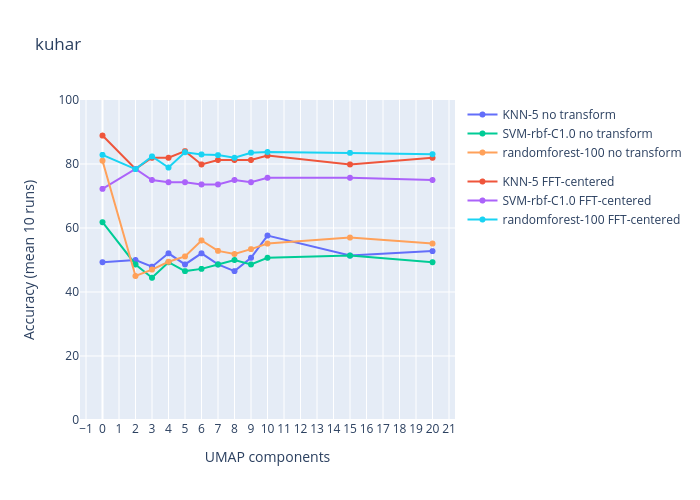

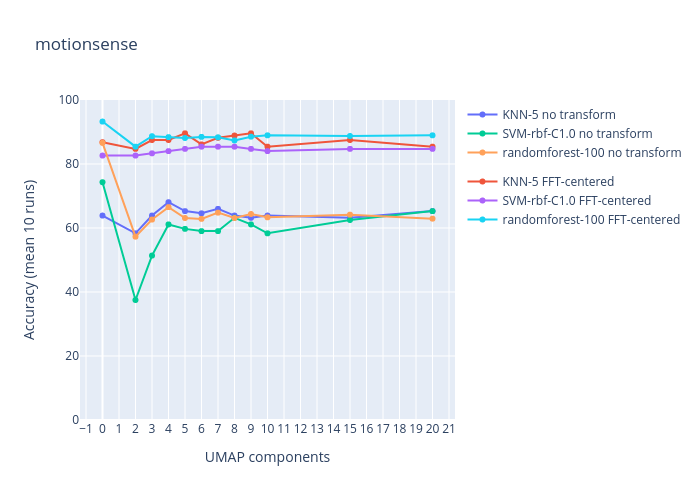

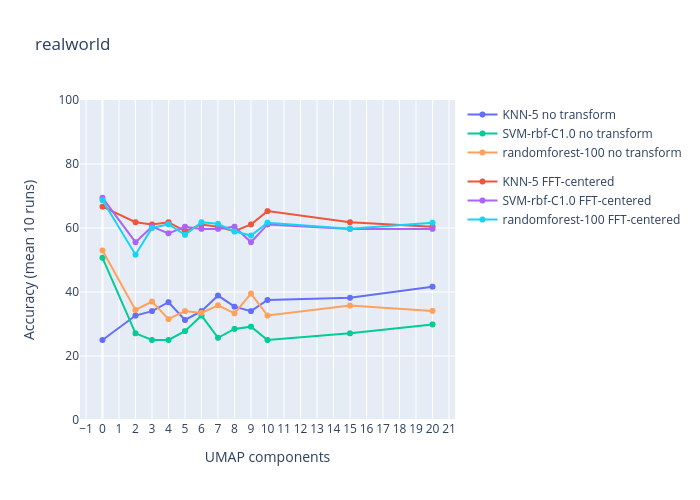

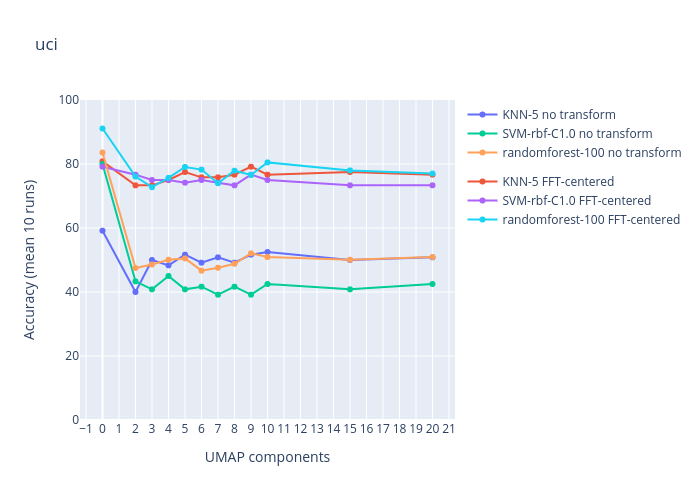

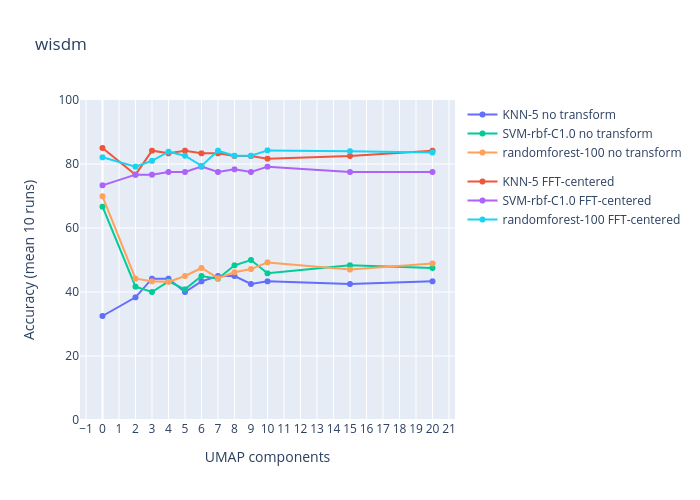

In [124]:
from IPython.display import display, HTML
import plotly.graph_objects as go


def only_standardized_view(df):
    return df[df["view"] == "standartized_intra_balanced"]


def only_raw_view(df):
    return df[df["view"] == "raw_balanced"]


def improvement_over_baseline(df):
    df = only_reduce_on_all(df)
    df = using_all_features(df)
    df = no_scaler(df)
    df = only_reducer_equals_train_or_no_reduce(df)
    df = only_standardized_view(df)

    for (train, test), subdf in df.groupby(
        [
            "train_datasets",
            "test_datasets",
        ]
    ):
        fig = go.Figure()
        for (estimator, transform), subsubdf in subdf.groupby(
            ["estimator", "transforms"]
        ):
            subsubdf = subsubdf[
                ~(subsubdf["reducer_datasets"] == "")
                | (subsubdf["umap components"] == 0)
            ]
            subsubdf = subsubdf.sort_values("umap components")
            transform = transform if transform else 'no transform'
            fig.add_trace(
                go.Scatter(
                    x=subsubdf["umap components"],
                    y=subsubdf["accuracy (mean)"]*100,
                    mode="lines+markers",
                    name=f"{estimator} {transform if transform else 'no transform'}",
                    legendgroup=transform
                )
            )

        fig.update_layout(
            title=f"{train}",
            xaxis_title="UMAP components",
            yaxis_title="Accuracy (mean 10 runs)",
            yaxis_range=[0, 100],
              xaxis = dict(
                tickmode = 'linear',
              )
        )
        fig.show("png")
        # break

    return df


x = improvement_over_baseline(results.copy())


# df = df.copy()
# df["improvement"] = df["accuracy"] - df["baseline_accuracy"]
# return df


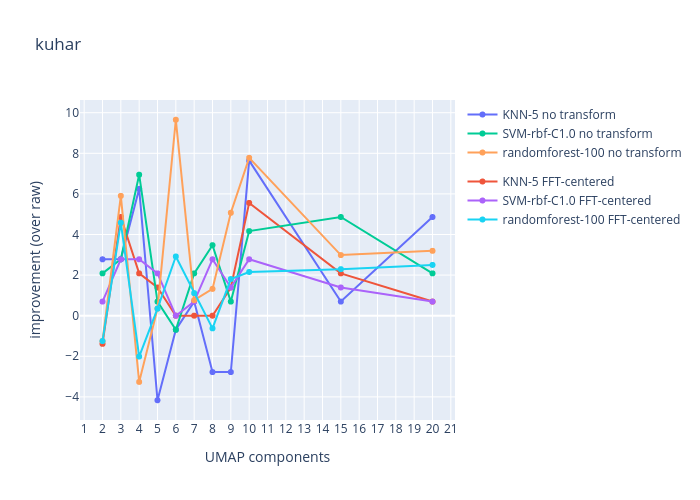

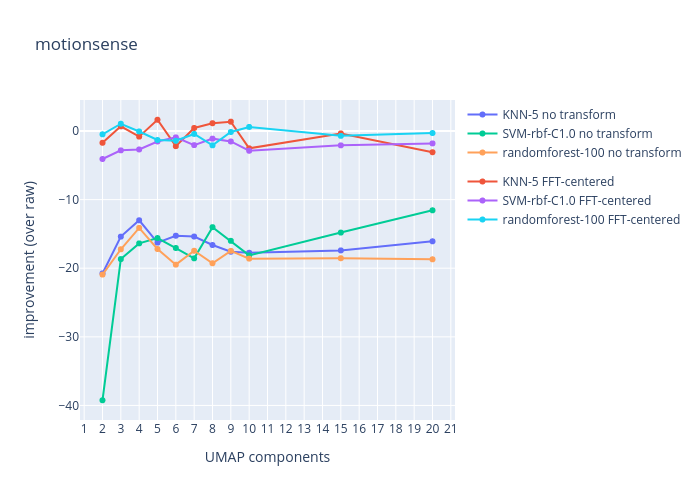

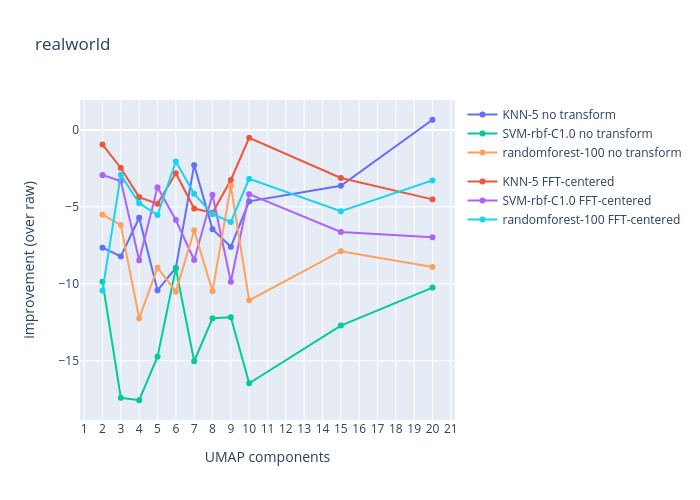

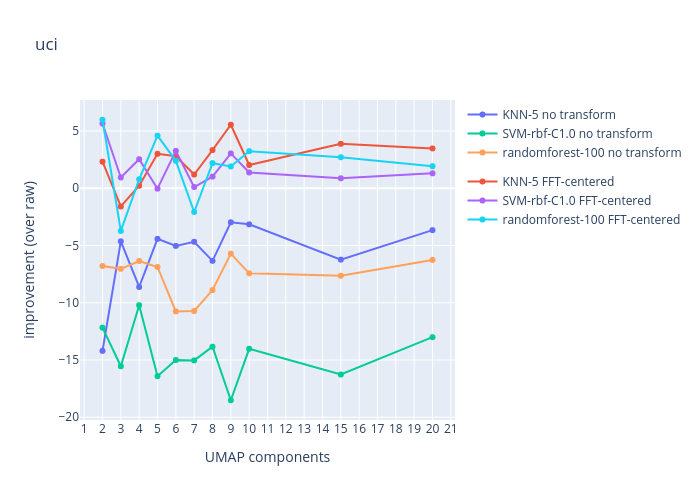

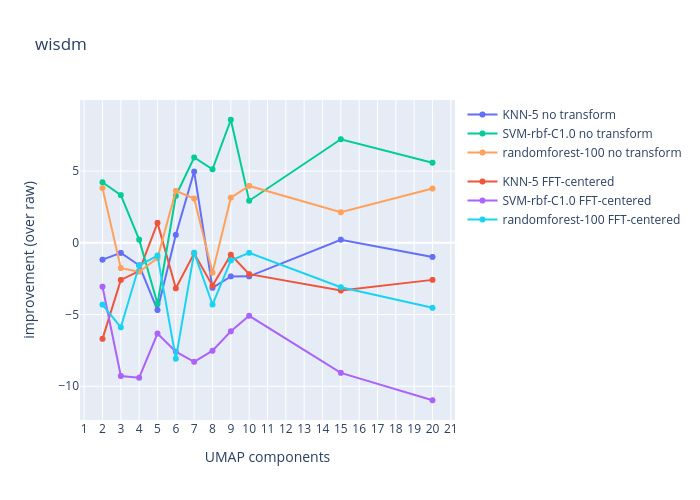

In [126]:
from IPython.display import display, HTML
import plotly.graph_objects as go


def only_standardized_view(df):
    return df[df["view"] == "standartized_intra_balanced"]


def only_raw_view(df):
    return df[df["view"] == "raw_balanced"]


def improvement_over_baseline(df):
    df = only_reduce_on_all(df)
    df = using_all_features(df)
    df = no_scaler(df)
    df = only_reducer_equals_train_or_no_reduce(df)
    raw_view = only_raw_view(df.copy())
    standard_df = only_standardized_view(df.copy())
    merged_df = raw_view.merge(standard_df, on=["config_group"], suffixes=("", "_y"))
    merged_df["improvement"] = merged_df["accuracy (mean)_y"] - merged_df["accuracy (mean)"]

    for (train, test), subdf in merged_df.groupby(
        [
            "train_datasets",
            "test_datasets",
        ]
    ):
        fig = go.Figure()
        for (estimator, transform), subsubdf in subdf.groupby(
            ["estimator", "transforms"]
        ):
            subsubdf = subsubdf[
                ~(subsubdf["reducer_datasets"] == "")
                | (subsubdf["umap components"] == 0)
            ]
            subsubdf = subsubdf.sort_values("umap components")
            transform = transform if transform else 'no transform'
            fig.add_trace(
                go.Scatter(
                    x=subsubdf["umap components"],
                    y=subsubdf["improvement"]*100,
                    mode="lines+markers",
                    name=f"{estimator} {transform if transform else 'no transform'}",
                    legendgroup=transform
                )
            )

        fig.update_layout(
            title=f"{train}",
            xaxis_title="UMAP components",
            yaxis_title="improvement (over raw)",
            # yaxis_range=[0, 1],
              xaxis = dict(
                tickmode = 'linear',
              )
        )
        fig.show("png")
        # break

    return df


x = improvement_over_baseline(results.copy())


# df = df.copy()
# df["improvement"] = df["accuracy"] - df["baseline_accuracy"]
# return df


## Pergunta 2: Como a escolha do dataset no treinamento do UMAP afeta os resultados da tarefa?

## Pergunta 3: É possível usar Manifold Learning para reduzir o domain shift?

## Pergunta 4: Qual a importância da normatização nos experimentos inter-dataset

## Pergunta 5: É mais vantajoso reduzir a dimensionalidade dos dados dos sensores de forma individual (aplicando o UMAP a um sensor, ou eixo, por vez) ou de forma agregada (como estamos fazendo)

## Pergunta 6: Há uma mudança significativa entre os diferentes classificadores


## Pergunta 7:  Melhor no domínio da frequência ou tempo (condicionada à abordagem - manifold learning com UMAP)? (ou wavelet?)

## Pergunta 8: Qual dataset (ou subconjunto de datasets) é mais propício para generalizar o reconhecimento de HAR?

## Pergunta 9: Normalização traz mais benefícios?

## Pergunta 10: Quais os sensores que ajudam mais: acelerômetro, giroscópio, ambos?